## Zak Phase calculation for graphene nanoribbons

Let's make graphene and try to compute the Zak phase for different cell size and shape

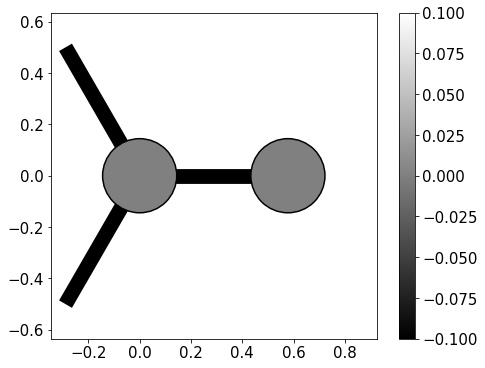

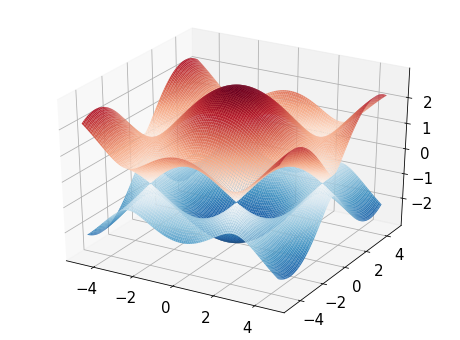

In [1]:
%run matplotlib_setup.ipy

from types import SimpleNamespace

from ipywidgets import interact
import matplotlib
from matplotlib import pyplot
from mpl_toolkits import mplot3d
import numpy as np
import scipy.linalg as la 
from math import floor
from helper import translate

import kwant
from kwant.wraparound import wraparound, plot_2d_bands


def momentum_to_lattice(k):
    """Transform momentum to the basis of reciprocal lattice vectors.
    
    See https://en.wikipedia.org/wiki/Reciprocal_lattice#Generalization_of_a_dual_lattice
    """
    B = np.array(graphene.prim_vecs).T
    A = B.dot(np.linalg.inv(B.T.dot(B)))
    return np.linalg.solve(A, k)


def dispersion_2D(syst, args=None, lim=1.5*np.pi, num_points=200):
    """A simple plot of 2D band structure."""
    if args is None:
        args = []
    momenta = np.linspace(-lim, lim, num_points)
    energies = []
    for kx in momenta:
        for ky in momenta:
            lattice_k = momentum_to_lattice([kx, ky])
            h = syst.hamiltonian_submatrix(args=(list(args) + list(lattice_k)))
            energies.append(np.linalg.eigvalsh(h))
    
    energies = np.array(energies).reshape(num_points, num_points, -1)
    emin, emax = np.min(energies), np.max(energies)
    kx, ky = np.meshgrid(momenta, momenta)
    fig = pyplot.figure()
    axes = fig.add_subplot(1, 1, 1, projection='3d')
    for band in range(energies.shape[-1]):
        axes.plot_surface(kx, ky, energies[:, :, band], cstride=2, rstride=2,
                          cmap=matplotlib.cm.RdBu_r, vmin=emin, vmax=emax,
                          linewidth=0.1)
        
#Some helper functions to make the schematic look neat
def family_color(site): 
    #if site.family == a or site.family==c: 
    #    return 0
    #else: 
    return 0
    
def hopping_lw(site1,site2): 
    return 0.1 if A in [site1.family,site2.family] else 0.05

graphene = kwant.lattice.general([[np.sqrt(3)/2,1/2],[np.sqrt(3)/2,-1/2]],  #Lattice vectors 
                                  [[0,0],[1/np.sqrt(3),0]]) # Co-ordinates
a,b = graphene.sublattices

bulk_graphene = kwant.Builder(kwant.TranslationalSymmetry(*graphene.prim_vecs))
bulk_graphene[graphene.shape((lambda pos: True), (0, 0))] = 0
bulk_graphene[graphene.neighbors(1)] = 1
kwant.plot(bulk_graphene,site_color=family_color,site_lw=0.01)
dispersion_2D(wraparound(bulk_graphene).finalized())

In [2]:
Zigzag = kwant.lattice.general([[1,0],[0,np.sqrt(3)/3]], #Lattice vectors
                                     [[1/6,0],[2/6,np.sqrt(3)/2],[4/6,np.sqrt(3)/2],[5/6,0]]) # Coordinates

a,b,c,d = Zigzag.sublattices

def get_width(N=7): 
    if N < 2: 
        raise("N cannot be less than 2")
    else:
        return N/2*Zigzag.prim_vecs[1][1]+0.01

def get_length(L):
    if L < 2:
        raise("L cannot be less than 2")
    else:
        return (L/2)*Zigzag.prim_vecs[0][0]
    
def make_1D_zigzag(N=7):
    #syst = kwant.Builder(kwant.TranslationalSymmetry(Zigzag.prim_vecs[0]))
    syst = kwant.Builder(kwant.TranslationalSymmetry([1,0]))
    syst[Zigzag.shape((lambda pos: pos[1] >0 and pos[1] <= get_width(N)),(0,0))] = 0
    syst[Zigzag.neighbors()] = -1
    return syst
def terminate_edges(syst,lattice,lat_vec): 
    sites = list(syst.sites())
    #print(sites)
    nsites = len(sites)
    pos = np.array([site.pos for site in sites])
    tags = [site.tag for site in sites]
    family = [site.family for site in sites]
    ymax = np.max(pos[:,1])
    ymin = np.min(pos[:,1])
    edge_index = []
    for i,p in enumerate(pos): 
        if abs(p[1] - ymax) < 1.e-2 or abs(p[1]-ymin) < 1.e-2: 
            edge_index.append(i)
    nedges = len(edge_index)
    #print(edge_index)
    edge_hoping_pairs = []
    for i in range(nedges): 
        site1 = sites[edge_index[i]]
        #print(site1.pos)
        neigh_sites = syst.neighbors(site1)
        for site2 in neigh_sites: 
            if abs(site2.pos[1] - ymax) < 1.0e-2  or abs(site2.pos[1]-ymin)< 1.0e-2:
                hop_pair = [site1.tag,site2.tag]
                pair_seen = hop_pair in edge_hoping_pairs
                if not pair_seen:
                    syst[site1,site2] = -1 - 0.1
                    edge_hoping_pairs.append([site1.tag,site2.tag])
                    #print(site1.pos)
                    #print(site2.pos)
    #print(edge_hoping_pairs)
    #print(edge_index)           
    return syst

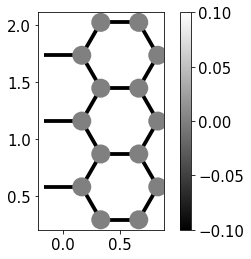

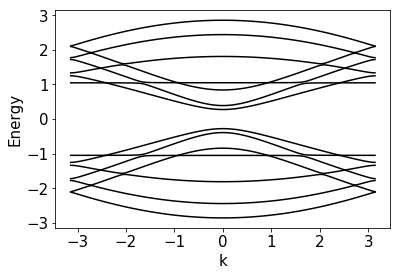

In [209]:
N=7
pos = [[1/6,0],[2/6,np.sqrt(3)/2],[4/6,np.sqrt(3)/2],[5/6,0]]
#N_list =[11]
pol_N={}
wcc_N={}
import z2pack
from Z2_compute import zak_bands as zak_bands_z2
Zigzag_1d = make_1D_zigzag(N=N)
#tpos = translate(pos,0.8,N,2)
Zigzag_1d = terminate_edges(Zigzag_1d,Zigzag,get_width(N))
kwant.plot(Zigzag_1d,site_color=family_color);
Zigzag_1d = Zigzag_1d.finalized()
kwant.plotter.bands(Zigzag_1d,momenta=101); 

In [210]:
from Zak_compute import zak_bands
spectrum,wf = zak_bands(Zigzag_1d,momenta=11,mom_start=-np.pi)
wf = np.array(wf)
num_modes = np.shape(wf)[-1]
p_gamma = []
for i in range(int(num_modes/2)): 
#for i in [0]:
    mode_raw= wf[5,:,i].tolist()
    pos = []
    for site in Zigzag_1d.sites: 
        x,y = site.pos 
        if 0<=x<=1: 
            pos.append([x,y]) 
#
    mode = [c for (c,_) in sorted(zip(mode_raw,pos),key=lambda coord: coord[1][0])]
    rmode = [c for (c,_) in sorted(zip(mode_raw,pos),key=lambda coord: (-1*coord[1][0],coord[1][1]))]
    added = np.array(mode) + np.array(rmode)
    subtracted = np.array(mode) - np.array(rmode)
    if np.sum(np.abs(added)) < 1.0e-4: 
        print("odd")
        p_gamma.append(-1)
        #print(np.abs(added))
    elif np.sum(np.abs(subtracted)) <1.0e-4: 
        print("even")
        p_gamma.append(1)
    else: 
        #print(added)
        #print(np.abs(subtracted))
        #print(np.abs(np.array(mode)-np.array(mode[::-1])))
        print(mode)
        print(rmode)

even
even
even
even
odd
odd
even


In [211]:
from Zak_compute import zak_bands
spectrum,wf = zak_bands(Zigzag_1d,momenta=11,mom_start=-np.pi)
wf = np.array(wf)
num_modes = np.shape(wf)[-1]
p_x = []
for i in range(int(num_modes/2)): 
#for i in [0]:
    mode_raw= wf[0,:,i].tolist()
    mode_rawk = wf[-1:,i].tolist()
    pos = []
    for site in Zigzag_1d.sites: 
        x,y = site.pos 
        if 0<=x<=1: 
            pos.append([x,y]) 
#
    mode = [c for (c,_) in sorted(zip(mode_raw,pos),key=lambda coord: coord[1][0])]
    #phase = np.angle(mode[0])
    #mode = np.array(mode)*np.exp(-1j*phase)
    #mode = mode.tolist()
    rmode = [c for (c,_) in sorted(zip(mode_raw,pos),key=lambda coord:(-1*coord[1][0],-1*coord[1][1]))]#,-1*coord[1][1]))]#,coord[1][1]))]
    added = np.array(mode) + np.array(rmode)
    subtracted = np.array(mode) - np.array(rmode)
    if np.sum(np.abs(added)) < 1.0e-4: 
        print("odd")
        p_x.append(-1)
        #print(np.abs(added))
    elif np.sum(np.abs(subtracted)) <1.0e-4: 
        print("even")
        p_x.append(1)
    else: 
        #print(np.abs(added))
        #print(np.abs(subtracted))
        #print(np.abs(np.array(mode)-np.array(mode[::-1])))
        print(mode)
        print(rmode)
        #print(mode)
        #print(np.imag(rmode))

#for j in range(np.shape(spectrum)[-1]):
#    plt.plot(spectrum[:,j])

even
odd
odd
even
even
odd
odd


In [212]:
prod = 1
for item in p_gamma + p_x: 
    prod *= item
print(prod)

1


In [185]:
sorted(pos, key=lambda pos: pos[0],reverse=True)

[[0.8333333333333334, 0.5773502691896257],
 [0.8333333333333334, 1.1547005383792515],
 [0.8333333333333334, 1.7320508075688772],
 [0.8333333333333334, 2.309401076758503],
 [0.8333333333333334, 2.8867513459481287],
 [0.8333333333333334, 3.4641016151377544],
 [0.8333333333333334, 4.04145188432738],
 [0.8333333333333334, 4.618802153517006],
 [0.8333333333333334, 5.196152422706632],
 [0.8333333333333334, 5.773502691896257],
 [0.6666666666666666, 0.28867513459481287],
 [0.6666666666666666, 0.8660254037844386],
 [0.6666666666666666, 1.4433756729740643],
 [0.6666666666666666, 2.02072594216369],
 [0.6666666666666666, 2.598076211353316],
 [0.6666666666666666, 3.1754264805429413],
 [0.6666666666666666, 3.7527767497325675],
 [0.6666666666666666, 4.330127018922193],
 [0.6666666666666666, 4.907477288111818],
 [0.6666666666666666, 5.484827557301444],
 [0.3333333333333333, 0.28867513459481287],
 [0.3333333333333333, 0.8660254037844386],
 [0.3333333333333333, 1.4433756729740643],
 [0.3333333333333333,

In [52]:
(np.array(mode1) + np.array(mode1[::-1])).tolist()

NameError: name 'mode1' is not defined

In [24]:
mode1

[(-1.2859455818764286e-16+3.123121557922961e-16j),
 (4.044507622752323e-17-6.130995285718243e-16j),
 (-6.569163947431468e-17+5.067049619515035e-16j),
 (-0.35355339059327273-5.290906601729263e-16j),
 (0.35355339059327345+2.0296264668928628e-16j),
 (-0.3535533905932738+1.110223024625156e-16j),
 (0.3535533905932744-7.979727989493313e-16j),
 (0.35355339059327345+5.830414299628573e-16j),
 (-0.35355339059327373-2.707292741705612e-16j),
 (0.3535533905932739-3.42370254401263e-16j),
 (-0.35355339059327445+8.490752163527662e-16j),
 (6.500183634911326e-17+0j),
 (-7.80362490812874e-17-7.395570986446986e-32j),
 (2.393810066912707e-16+2.465190328815662e-32j)]

In [36]:
spectrum[0]

array([-2.85552737, -2.44034975, -1.80904091, -1.04993758, -0.84083843,
       -0.39028732, -0.27627016,  0.27627016,  0.39028732,  0.84083843,
        1.04993758,  1.80904091,  2.44034975,  2.85552737])

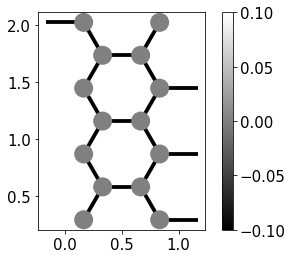


+----------------------------------------------------------------------+
|        ================                                              |
|        LINE CALCULATION                                              |
|        ================                                              |
|        starting at 2019-06-03 19:18:38,637                           |
|        running Z2Pack version 2.1.1                                  |
|                                                                      |
|        init_result: None                                             |
|        iterator:    range(200, 500, 2)                               |
|        line:        <function <lambda> at 0x117184488>               |
|        load:        False                                            |
|        load_quiet:  True                                             |
|        pos_tol:     0.001                                            |
|        save_file:   None                        

In [43]:
def make_syst(lat,N=7):
    #syst = kwant.Builder(kwant.TranslationalSymmetry(Zigzag.prim_vecs[0]))
    syst = kwant.Builder(kwant.TranslationalSymmetry([1,0]))
    syst[lat.shape((lambda pos: pos[1] >0 and pos[1] <= get_width(N)),(0,0))] = 0
    syst[lat.neighbors()] = -1
    return syst

def translate(pos,t): 
    pos = np.array(pos)
    pos[:,0] +=  t
    for p in pos: 
        if p[0] > 1: 
            p[0] -= 1
        if p[0] < 0: 
            p[0] += 1 
    return pos 

pos = [[1/6,0],[2/6,np.sqrt(3)/2],[4/6,np.sqrt(3)/2],[5/6,0]]
gap = []

#for t in np.linspace(0,0.5,100):
for t in [0.5]:
    tpos = translate(pos,t)
    tZigzag = kwant.lattice.general([[1,0],[0,np.sqrt(3)/3]], #Lattice vectors
                                     tpos)
    tsyst = make_syst(tZigzag)
    tsyst = terminate_edges(tsyst,tZigzag,get_width(N))
    kwant.plot(tsyst,site_color=family_color);
    tsyst = tsyst.finalized()
    #kwant.plotter.bands(tsyst,momenta=1001);
    bands = kwant.physics.Bands(tsyst)
    gamma_E = bands(0)
    nbands = len(gamma_E)
    gap0  = gamma_E[int(nbands/2)] - gamma_E[int(nbands/2)-1]
    
    
    ham_k=zak_bands_z2(tsyst,momenta=1001,dim=1)
    z2_system = z2pack.hm.System(ham_k,dim=1,#pos=red_pos,
                                 convention=2)
    pol_sum = 0

    result1 = z2pack.line.run(system=z2_system, 
                                line=lambda t1: [t1],#,n/(N+1)])#,
                                pos_tol=1e-3,iterator=range(200,500,2));

    
    gap.append([t,gap0,result1.pol])
#print(gamma_E)
#print(gap)

In [75]:
from Zak_compute import zak_bands
spectrum,wf = zak_bands(tsyst,momenta=11)
wf = np.array(wf)
mode1 = wf[10,:,0].tolist()
pos = []
for site in tsyst.sites: 
    x,y = site.pos 
    if 0<=x<=1: 
        pos.append([x,y])
mode1 = [c for (c,_) in sorted(zip(mode1,pos),key=lambda coord: coord[1][0])]
sorted(pos,key=lambda x: x[0])

[[0.16666666666666652, 0.28867513459481287],
 [0.16666666666666652, 0.8660254037844386],
 [0.16666666666666652, 1.4433756729740643],
 [0.16666666666666652, 2.02072594216369],
 [0.3333333333333335, 0.5773502691896257],
 [0.3333333333333335, 1.1547005383792515],
 [0.3333333333333335, 1.7320508075688772],
 [0.6666666666666666, 0.5773502691896257],
 [0.6666666666666666, 1.1547005383792515],
 [0.6666666666666666, 1.7320508075688772],
 [0.8333333333333333, 0.28867513459481287],
 [0.8333333333333333, 0.8660254037844386],
 [0.8333333333333333, 1.4433756729740643],
 [0.8333333333333333, 2.02072594216369]]

In [49]:
(np.array(mode1) - np.array(mode1[::-1])).tolist()

[(0.36228830404697965+6.702362808724049e-16j),
 (0.7800591796730525+1.4431157661017054e-15j),
 (0.7800591796730524+1.4431157661017042e-15j),
 (0.36228830404697987+6.70236280872403e-16j),
 (0.36696958510877975+6.78896688546435e-16j),
 (0.5011749885292723+9.271777659556188e-16j),
 (0.36696958510877936+6.788966885464286e-16j),
 (-0.36696958510877936-6.788966885464286e-16j),
 (-0.5011749885292723-9.271777659556188e-16j),
 (-0.36696958510877975-6.78896688546435e-16j),
 (-0.36228830404697987-6.70236280872403e-16j),
 (-0.7800591796730524-1.4431157661017042e-15j),
 (-0.7800591796730525-1.4431157661017054e-15j),
 (-0.36228830404697965-6.702362808724049e-16j)]

In [50]:
mode1

[(0.1811441520234913+6.702362808724042e-16j),
 (0.3900295898365305+1.5575737651584195e-15j),
 (0.3900295898365306+1.5575737651584186e-15j),
 (0.18114415202349182+6.70236280872403e-16j),
 (0.18348479255439523+1.3917544608504958e-15j),
 (0.2505874942646438+1.9659696683753433e-15j),
 (0.1834847925543952+1.391754460850492e-15j),
 (-0.18348479255438416+7.128577723040634e-16j),
 (-0.25058749426462856+1.0387919024197244e-15j),
 (-0.18348479255438455+7.128577723040608e-16j),
 (-0.18114415202348808+0j),
 (-0.3900295898365218+1.1445799905671435e-16j),
 (-0.39002958983652203+1.144579990567141e-16j),
 (-0.18114415202348833-6.902532920683853e-31j)]

In [51]:
spectrum[0]

array([-2.85552737, -2.44034975, -1.80904091, -1.04993758, -0.84083843,
       -0.39028732, -0.27627016,  0.27627016,  0.39028732,  0.84083843,
        1.04993758,  1.80904091,  2.44034975,  2.85552737])

In [ ]:


#for N in N_list:
    # Making a Zigzag lead
    Zigzag_1d = make_1D_zigzag(N=N)
    #site_value = Zigzag_1d.site_value_pairs()
    Zigzag_1d = terminate_edges(Zigzag_1d,Zigzag,get_width(N))
    #for site in list(Zigzag_1d.sites()):
        #print(site_value(site))
     #   if site.family == a or site.family == c: 
        #    Zigzag_1d[site.family(site.tag[0],site.tag[1])] = 0.1
      #  else:
       #     Zigzag_1d[site.family(site.tag[0],site.tag[1])] = -0.1
    #Zigzag_1d[Zigzag.neighbors(2)] = 0.005
    kwant.plot(Zigzag_1d,site_color=family_color);
    Zigzag_1d = Zigzag_1d.finalized()
    kwant.plotter.bands(Zigzag_1d,momenta=100001);

    act_pos = np.array([Zigzag_1d.pos(i) for i in range(2*N)])
    a1,a2 = [Zigzag.prim_vecs[0][0],get_width(N=N)]
    red_pos = np.zeros(np.shape(act_pos))
    red_pos[:,0] = act_pos[:,0]/a1
    red_pos[:,1] = act_pos[:,1]/a2


    ham_k=zak_bands_z2(Zigzag_1d,momenta=100001,dim=2)
    z2_system = z2pack.hm.System(ham_k,dim=2,pos=red_pos,
                                 convention=2)
    pol_sum = 0
    for n in range(0,1):
        result1 = z2pack.line.run(system=z2_system, 
                                 line=lambda t1: [t1,0],#,n/(N+1)])#,
                                 pos_tol=1e-3,iterator=range(3,501,2));
    #np.exp(-1*2*np.pi*np.sum(np.log(np.diagonal(result.wilson))))
    #result.pol
        #result12 = z2pack.line.run(system=z2_system, 
        #                         line=lambda t1: [t1,-n/(N+1)],
        #                         pos_tol=1e-2)
        pol_sum += result1.pol
        #pol_sum += result2.pol
        
    
    #pol_N[N] = np.sign(np.exp(-1j*2*np.pi*(pol_sum % 1)))
    pol_N[N] = pol_sum % 1
    wcc_N[N] = result1.wcc

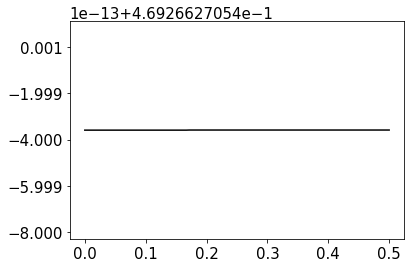

In [18]:
gap = np.array(gap)
plt.plot(gap[:,0],gap[:,1])

In [19]:
gap

array([[0.        , 0.46926627],
       [0.00505051, 0.46926627],
       [0.01010101, 0.46926627],
       [0.01515152, 0.46926627],
       [0.02020202, 0.46926627],
       [0.02525253, 0.46926627],
       [0.03030303, 0.46926627],
       [0.03535354, 0.46926627],
       [0.04040404, 0.46926627],
       [0.04545455, 0.46926627],
       [0.05050505, 0.46926627],
       [0.05555556, 0.46926627],
       [0.06060606, 0.46926627],
       [0.06565657, 0.46926627],
       [0.07070707, 0.46926627],
       [0.07575758, 0.46926627],
       [0.08080808, 0.46926627],
       [0.08585859, 0.46926627],
       [0.09090909, 0.46926627],
       [0.0959596 , 0.46926627],
       [0.1010101 , 0.46926627],
       [0.10606061, 0.46926627],
       [0.11111111, 0.46926627],
       [0.11616162, 0.46926627],
       [0.12121212, 0.46926627],
       [0.12626263, 0.46926627],
       [0.13131313, 0.46926627],
       [0.13636364, 0.46926627],
       [0.14141414, 0.46926627],
       [0.14646465, 0.46926627],
       [0.

In [ ]:
bands = kwant.physics.Bands(Zigzag_1d)
energies = bands(0) 
energies

# Zigzag'

In [ ]:
Zigzag_dash = kwant.lattice.general([[1,0],[0,np.sqrt(3)/3]], #Lattice vectors
                                     [[1/6,0],[2/6,-np.sqrt(3)/2],[4/6,-np.sqrt(3)/2],[5/6,0]]) # Coordinates

def get_width_dash(N=7): 
    #if N < 2: 
        #raise("N cannot be less than 2")
    #else:
    return N/2*Zigzag_dash.prim_vecs[1][1]

def make_1D_zigzag_dash(N=7):
    syst = kwant.Builder(kwant.TranslationalSymmetry(Zigzag_dash.prim_vecs[0]))
    syst[Zigzag_dash.shape((lambda pos: pos[1] >-1*get_width_dash(1) and pos[1] <= get_width_dash(N-1)),(0,0))] = 0
    syst[Zigzag_dash.neighbors()] = -1
    return syst

In [ ]:
#N_list =[3,11,5,7,9,8,10,4,6,13,15,23,17,19,21,12,20,22,14,16,18]
N_list =[14]
pol_N={}
import z2pack
from Z2_compute import zak_bands as zak_bands_z2
for N in N_list:
    # Making a Zigzag lead
    Zigzag_1d_dash = make_1D_zigzag_dash(N=N) 
    Zigzag_1d_dash = terminate_edges(Zigzag_1d_dash,Zigzag,get_width(N))
    #Zigzag_1d_dash[Zigzag.neighbors(2)] = 0.001
    kwant.plot(Zigzag_1d_dash,site_color=family_color);
    Zigzag_1d_dash = Zigzag_1d_dash.finalized()
    kwant.plotter.bands(Zigzag_1d_dash);

    #act_pos = np.array([Zigzag_1d_dash.pos(i) for i in range(2*N)])
    #a1,a2 = [Zigzag_dash.prim_vecs[0][0],get_width(N=N)]
    #red_pos = np.zeros(np.shape(act_pos))
    #red_pos[:,0] = act_pos[:,0]/a1
    #red_pos[:,1] = act_pos[:,1]/a2


    ham_k=zak_bands_z2(Zigzag_1d_dash,momenta=1001,dim=1)
    z2_system = z2pack.hm.System(ham_k,dim=1,#pos=red_pos,
                                 convention=2)
    pol_sum = 0
    for n in range(0,1):
        result1 = z2pack.line.run(system=z2_system, 
                                 line=lambda t1: [t1],#,n/(N+1)])#,
                                 pos_tol=1e-3,iterator=range(200,500,2));
    #np.exp(-1*2*np.pi*np.sum(np.log(np.diagonal(result.wilson))))
    #result.pol
        #result12 = z2pack.line.run(system=z2_system, 
        #                         line=lambda t1: [t1,-n/(N+1)],
        #                         pos_tol=1e-2)
        pol_sum += result1.pol
        #pol_sum += result2.pol
        
    
    pol_N[N] = pol_sum % 1
    z2 = np.sign(np.exp(1j*2*np.pi*pol_N[N]))

In [ ]:
pol_N

## Bearded

In [ ]:
Bearded = kwant.lattice.general([[1,0],[0,np.sqrt(3)/3]], #Lattice vectors
                                     [[0.5/6,np.sqrt(3)/2],[2.5/6,np.sqrt(3)/2],[3.5/6,0],[5.5/6,0]]) # Coordinates

def get_width(N=7): 
    if N < 2: 
        raise("N cannot be less than 2")
    else:
        return N/2*Zigzag.prim_vecs[1][1]+0.01

def make_1D_bearded(N=7):
    syst = kwant.Builder(kwant.TranslationalSymmetry(Bearded.prim_vecs[0]))
    syst[Bearded.shape((lambda pos: pos[1] >0 and pos[1] <= get_width(N)),(0,0))] = 0
    syst[Bearded.neighbors()] = -1
    return syst

In [ ]:
N_list =[4,10,12,14,6,8,16,22,24,26,18,20]
pol_N={}
import z2pack
from Z2_compute import zak_bands as zak_bands_z2
for N in N_list:
    # Making a Zigzag lead
    beard_1d = make_1D_bearded(N=N) 
    #beard_1d[Bearded.neighbors(2)] = 0.001
    beard_1d = terminate_edges(beard_1d,Bearded,get_width(N))
    kwant.plot(beard_1d,site_color=family_color);
    beard_1d = beard_1d.finalized()
    kwant.plotter.bands(beard_1d);

    act_pos = np.array([beard_1d.pos(i) for i in range(2*N)])
    a1,a2 = [Bearded.prim_vecs[0][0],get_width(N=N)]
    red_pos = np.zeros(np.shape(act_pos))
    red_pos[:,0] = act_pos[:,0]/a1
    red_pos[:,1] = act_pos[:,1]/a2


    ham_k=zak_bands_z2(beard_1d,momenta=1001,dim=1)
    z2_system = z2pack.hm.System(ham_k,dim=1,#pos=red_pos,
                                 convention=2)
    pol_sum = 0
    for n in range(0,1):
        result1 = z2pack.line.run(system=z2_system, 
                                 line=lambda t1: [t1])#,n/(N+1)])#,
                                 #pos_tol=1e-3,iterator=range(200,500,2));
    #np.exp(-1*2*np.pi*np.sum(np.log(np.diagonal(result.wilson))))
    #result.pol
        #result12 = z2pack.line.run(system=z2_system, 
        #                         line=lambda t1: [t1,-n/(N+1)],
        #                         pos_tol=1e-2)
        pol_sum += result1.pol
        #pol_sum += result2.pol
        
    
    #pol_N[N] = np.sign(np.exp(-1j*2*np.pi*(pol_sum % 1)))
    pol_N[N] = pol_sum % 1

In [ ]:
pol_N